In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size']      = 12
plt.rcParams['axes.grid']      = True
plt.rcParams['grid.alpha']     = 0.3
sns.set_palette("husl")

# ============================================================
# Load cleaned data
# ============================================================
df = pd.read_csv('cleaned_data2/karachi_cleaned2.csv')

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time
df = df.sort_values('timestamp').reset_index(drop=True)

# ============================================================
# Quick overview
# ============================================================
print("✅ Data loaded successfully!")
print(f"\n📊 Shape:   {df.shape}")
print(f"📅 From:    {df['timestamp'].min()}")
print(f"📅 To:      {df['timestamp'].max()}")
print(f"📊 Columns: {df.columns.tolist()}")
print(f"\n🔢 Missing Values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
print(f"\n📋 Data Types:\n{df.dtypes}")
print(f"\n📋 Basic Stats:")
display(df.describe().round(2))

✅ Data loaded successfully!

📊 Shape:   (4200, 39)
📅 From:    2025-08-09 19:00:00
📅 To:      2026-02-02 18:00:00
📊 Columns: ['timestamp', 'city', 'aqi', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'hour', 'day_of_week', 'month', 'day', 'is_weekend', 'season', 'is_rush_hour', 'aqi_lag_1h', 'aqi_lag_3h', 'aqi_lag_6h', 'aqi_lag_12h', 'aqi_lag_24h', 'aqi_change_1h', 'aqi_change_24h', 'aqi_change_rate_1h', 'aqi_change_rate_24h', 'aqi_rolling_mean_3h', 'aqi_rolling_mean_6h', 'aqi_rolling_mean_12h', 'aqi_rolling_mean_24h', 'aqi_rolling_std_24h', 'aqi_rolling_min_24h', 'aqi_rolling_max_24h', 'pm25_lag_24h', 'pm25_change_24h', 'pm25_rolling_mean_24h', 'is_aqi_rising', 'target_aqi_1d', 'target_aqi_2d', 'target_aqi_3d']

🔢 Missing Values:
Series([], dtype: int64)

📋 Data Types:
timestamp                datetime64[us]
city                                str
aqi                             float64
pm25                            float64
pm10                            float64
o3                      

,timestamp,aqi,pm25,pm10,o3,no2,so2,co,hour,day_of_week,...,aqi_rolling_std_24h,aqi_rolling_min_24h,aqi_rolling_max_24h,pm25_lag_24h,pm25_change_24h,pm25_rolling_mean_24h,is_aqi_rising,target_aqi_1d,target_aqi_2d,target_aqi_3d
count,4200,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,...,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00,4200.00
mean,2025-11-05 11:18:41.142857,93.56,38.60,83.47,95.83,0.68,3.78,189.53,11.50,3.01,...,10.19,78.02,108.77,38.33,0.28,38.39,0.34,94.30,94.96,95.57
min,2025-08-09 19:00:00,9.00,2.20,5.63,30.14,0.02,0.06,68.22,0.00,0.00,...,0.41,9.00,10.00,2.20,-144.51,2.34,0.00,9.00,0.00,0.00
25%,2025-09-22 12:45:00,51.00,12.31,36.20,47.17,0.08,0.29,91.66,5.75,1.00,...,3.19,35.00,60.00,12.40,-5.10,12.46,0.00,52.00,52.00,53.00
50%,2025-11-05 06:30:00,76.00,24.04,72.34,104.79,0.17,0.74,131.42,11.50,3.00,...,6.87,63.00,96.00,23.76,-0.32,25.16,0.00,78.00,79.00,80.00
75%,2025-12-19 00:15:00,151.00,55.89,112.07,131.11,1.19,7.26,270.38,17.25,5.00,...,12.80,110.00,159.00,55.52,6.81,55.32,1.00,152.00,152.00,152.00
max,2026-02-02 18:00:00,310.00,262.00,414.47,208.98,6.95,23.33,824.50,23.00,6.00,...,73.29,229.00,310.00,262.00,146.03,207.59,1.00,310.00,310.00,310.00
std,NaN,55.74,37.70,62.39,42.83,0.87,4.46,126.10,6.92,2.02,...,10.46,49.50,59.78,37.49,24.25,36.05,0.48,55.95,56.11,56.18


In [3]:
# Quick sanity check before feature selection
print("="*60)
print("🔍 DATA VERIFICATION")
print("="*60)

# Check targets exist
targets = ['target_aqi_1d', 'target_aqi_2d', 'target_aqi_3d']
for t in targets:
    status = "✅" if t in df.columns else "❌ MISSING"
    print(f"  {status} {t}")

# Check key features exist
key_features = ['aqi', 'pm25', 'pm10', 'o3', 'no2', 
                'so2', 'co', 'hour', 'season']
print(f"\n📋 Key Features:")
for f in key_features:
    status = "✅" if f in df.columns else "❌ MISSING"
    print(f"  {status} {f}")

# Season distribution
if 'season' in df.columns:
    print(f"\n🌦️  Season Distribution:")
    print(df['season'].value_counts())

# AQI range
print(f"\n📈 AQI Range: {df['aqi'].min():.1f} to {df['aqi'].max():.1f}")
print(f"📈 AQI Mean:  {df['aqi'].mean():.1f}")

print(f"\n✅ Data is ready for feature selection!")
display(df.head(3))

🔍 DATA VERIFICATION
  ✅ target_aqi_1d
  ✅ target_aqi_2d
  ✅ target_aqi_3d

📋 Key Features:
  ✅ aqi
  ✅ pm25
  ✅ pm10
  ✅ o3
  ✅ no2
  ✅ so2
  ✅ co
  ✅ hour
  ✅ season

🌦️  Season Distribution:
season
autumn    2184
winter    1483
summer     533
Name: count, dtype: int64

📈 AQI Range: 9.0 to 310.0
📈 AQI Mean:  93.6

✅ Data is ready for feature selection!


,timestamp,city,aqi,pm25,pm10,o3,no2,so2,co,hour,...,aqi_rolling_std_24h,aqi_rolling_min_24h,aqi_rolling_max_24h,pm25_lag_24h,pm25_change_24h,pm25_rolling_mean_24h,is_aqi_rising,target_aqi_1d,target_aqi_2d,target_aqi_3d
0,2025-08-09 19:00:00,karachi,53.0,12.83,62.90,37.95,0.06,0.30,72.90,19,...,0.707107,53.0,53.0,12.83,0.0,12.830000,0,51.0,42.0,54.0
1,2025-08-09 20:00:00,karachi,52.0,12.79,62.97,37.50,0.07,0.30,71.46,20,...,0.707107,52.0,53.0,12.83,0.0,12.810000,0,48.0,40.0,54.0
2,2025-08-09 21:00:00,karachi,51.0,12.31,60.58,37.33,0.07,0.31,70.27,21,...,1.000000,51.0,53.0,12.83,0.0,12.643333,0,45.0,39.0,54.0


In [13]:
# ============================================================
# METHOD 1: CORRELATION WITH TARGETS
# ============================================================
print("\n" + "="*65)
print("📊 METHOD 1: CORRELATION WITH TARGETS")
print("="*65)

corr_results = {}

for feat in all_feature_cols:
    corr_1d = abs(df_ml[[feat, 'target_aqi_1d']].dropna().corr().iloc[0,1])
    corr_2d = abs(df_ml[[feat, 'target_aqi_2d']].dropna().corr().iloc[0,1])
    corr_3d = abs(df_ml[[feat, 'target_aqi_3d']].dropna().corr().iloc[0,1])
    max_corr = max(corr_1d, corr_2d, corr_3d)

    corr_results[feat] = {
        'corr_1d': round(corr_1d, 3),
        'corr_2d': round(corr_2d, 3),
        'corr_3d': round(corr_3d, 3),
        'max_corr': round(max_corr, 3)
    }

corr_df_results = pd.DataFrame(corr_results).T
corr_df_results = corr_df_results.sort_values('max_corr', ascending=False)

print(f"\n{'Feature':<30} {'Day1':>8} {'Day2':>8} {'Day3':>8} {'Max':>8}")
print("-"*65)
for feat, row in corr_df_results.iterrows():
    strength = "🔴 STRONG" if row['max_corr'] >= 0.7 else \
               "🟡 MODERATE" if row['max_corr'] >= 0.4 else \
               "🟢 WEAK"
    print(f"{feat:<30} {row['corr_1d']:>8.3f} {row['corr_2d']:>8.3f} "
          f"{row['corr_3d']:>8.3f} {row['max_corr']:>8.3f}  {strength}")


📊 METHOD 1: CORRELATION WITH TARGETS

Feature                            Day1     Day2     Day3      Max
-----------------------------------------------------------------
aqi                               0.794    0.644    0.573    0.794  🔴 STRONG
aqi_rolling_mean_3h               0.785    0.641    0.571    0.785  🔴 STRONG
aqi_lag_1h                        0.784    0.640    0.570    0.784  🔴 STRONG
aqi_rolling_mean_6h               0.773    0.637    0.569    0.773  🔴 STRONG
aqi_rolling_max_24h               0.772    0.675    0.596    0.772  🔴 STRONG
aqi_lag_3h                        0.764    0.632    0.565    0.764  🔴 STRONG
aqi_rolling_mean_12h              0.752    0.631    0.568    0.752  🔴 STRONG
o3                                0.742    0.683    0.653    0.742  🔴 STRONG
pm25                              0.739    0.582    0.492    0.739  🔴 STRONG
pm10                              0.735    0.556    0.451    0.735  🔴 STRONG
aqi_lag_6h                        0.734    0.618    0.557 

In [6]:
# ============================================================
# METHOD 1: CORRELATION WITH TARGETS
# ============================================================
print("\n" + "="*65)
print("📊 METHOD 1: CORRELATION WITH TARGETS")
print("="*65)

corr_results = {}

for feat in all_feature_cols:
    corr_1d = abs(df_ml[[feat, 'target_aqi_1d']].dropna().corr().iloc[0,1])
    corr_2d = abs(df_ml[[feat, 'target_aqi_2d']].dropna().corr().iloc[0,1])
    corr_3d = abs(df_ml[[feat, 'target_aqi_3d']].dropna().corr().iloc[0,1])
    max_corr = max(corr_1d, corr_2d, corr_3d)

    corr_results[feat] = {
        'corr_1d': round(corr_1d, 3),
        'corr_2d': round(corr_2d, 3),
        'corr_3d': round(corr_3d, 3),
        'max_corr': round(max_corr, 3)
    }

corr_df_results = pd.DataFrame(corr_results).T
corr_df_results = corr_df_results.sort_values('max_corr', ascending=False)

print(f"\n{'Feature':<30} {'Day1':>8} {'Day2':>8} {'Day3':>8} {'Max':>8}")
print("-"*65)
for feat, row in corr_df_results.iterrows():
    strength = "🔴 STRONG" if row['max_corr'] >= 0.7 else \
               "🟡 MODERATE" if row['max_corr'] >= 0.4 else \
               "🟢 WEAK"
    print(f"{feat:<30} {row['corr_1d']:>8.3f} {row['corr_2d']:>8.3f} "
          f"{row['corr_3d']:>8.3f} {row['max_corr']:>8.3f}  {strength}")


📊 METHOD 1: CORRELATION WITH TARGETS

Feature                            Day1     Day2     Day3      Max
-----------------------------------------------------------------
aqi                               0.794    0.644    0.573    0.794  🔴 STRONG
aqi_rolling_mean_3h               0.785    0.641    0.571    0.785  🔴 STRONG
aqi_lag_1h                        0.784    0.640    0.570    0.784  🔴 STRONG
aqi_rolling_mean_6h               0.773    0.637    0.569    0.773  🔴 STRONG
aqi_rolling_max_24h               0.772    0.675    0.596    0.772  🔴 STRONG
aqi_lag_3h                        0.764    0.632    0.565    0.764  🔴 STRONG
aqi_rolling_mean_12h              0.752    0.631    0.568    0.752  🔴 STRONG
o3                                0.742    0.683    0.653    0.742  🔴 STRONG
pm25                              0.739    0.582    0.492    0.739  🔴 STRONG
pm10                              0.735    0.556    0.451    0.735  🔴 STRONG
aqi_lag_6h                        0.734    0.618    0.557 

In [7]:
# ============================================================
# METHOD 2: RANDOM FOREST FEATURE IMPORTANCE
# ============================================================
print("\n" + "="*65)
print("🤖 METHOD 2: RANDOM FOREST FEATURE IMPORTANCE")
print("="*65)
print("⏳ Training Random Forest... (~1 minute)")

# Prepare
df_rf = df_ml[all_feature_cols + ['target_aqi_1d']].dropna()
X = df_rf[all_feature_cols]
y = df_rf['target_aqi_1d']

# Train
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# Importance
importance_df = pd.DataFrame({
    'feature': all_feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print(f"\n{'Rank':<5} {'Feature':<30} {'Importance':>12} {'Cumulative':>12}")
print("-"*65)

cumulative = 0
for i, row in importance_df.iterrows():
    cumulative += row['importance']
    tier = "🔴 HIGH" if row['importance'] >= 0.05 else \
           "🟡 MED"  if row['importance'] >= 0.01 else \
           "🟢 LOW"
    print(f"{i+1:<5} {row['feature']:<30} "
          f"{row['importance']:>12.4f} "
          f"{cumulative:>11.1%}  {tier}")


🤖 METHOD 2: RANDOM FOREST FEATURE IMPORTANCE
⏳ Training Random Forest... (~1 minute)

Rank  Feature                          Importance   Cumulative
-----------------------------------------------------------------
1     aqi_rolling_max_24h                  0.5150       51.5%  🔴 HIGH
2     pm10                                 0.0751       59.0%  🔴 HIGH
3     no2                                  0.0680       65.8%  🔴 HIGH
4     month                                0.0543       71.2%  🔴 HIGH
5     pm25                                 0.0448       75.7%  🟡 MED
6     day                                  0.0348       79.2%  🟡 MED
7     co                                   0.0331       82.5%  🟡 MED
8     so2                                  0.0186       84.4%  🟡 MED
9     o3                                   0.0173       86.1%  🟡 MED
10    aqi_rolling_min_24h                  0.0151       87.6%  🟡 MED
11    aqi_lag_12h                          0.0137       89.0%  🟡 MED
12    aqi_rolling_mea

In [8]:
# ============================================================
# METHOD 3: COMBINED SCORE (Correlation + RF Importance)
# ============================================================
print("\n" + "="*65)
print("🎯 METHOD 3: COMBINED SCORE")
print("="*65)

# Normalize both scores to 0-1
corr_scores  = corr_df_results['max_corr']
imp_scores   = importance_df.set_index('feature')['importance']

# Normalize
corr_norm = (corr_scores  - corr_scores.min())  / (corr_scores.max()  - corr_scores.min())
imp_norm  = (imp_scores   - imp_scores.min())   / (imp_scores.max()   - imp_scores.min())

# Combined score (equal weight)
combined = pd.DataFrame({
    'corr_score': corr_norm,
    'rf_score':   imp_norm
}).fillna(0)

combined['combined_score'] = (
    combined['corr_score'] * 0.5 +
    combined['rf_score']   * 0.5
)

combined = combined.sort_values('combined_score', ascending=False)

print(f"\n{'Feature':<30} {'Corr':>8} {'RF':>8} {'Combined':>10} {'Decision'}")
print("-"*70)

KEEP_THRESHOLD = 0.3  # Combined score threshold

keep_list   = []
drop_list   = []

for feat, row in combined.iterrows():
    decision = "✅ KEEP" if row['combined_score'] >= KEEP_THRESHOLD \
               else "❌ DROP"

    if row['combined_score'] >= KEEP_THRESHOLD:
        keep_list.append(feat)
    else:
        drop_list.append(feat)

    print(f"{feat:<30} {row['corr_score']:>8.3f} "
          f"{row['rf_score']:>8.3f} "
          f"{row['combined_score']:>10.3f}  {decision}")


🎯 METHOD 3: COMBINED SCORE

Feature                            Corr       RF   Combined Decision
----------------------------------------------------------------------
aqi_rolling_max_24h               0.972    1.000      0.986  ✅ KEEP
pm10                              0.925    0.146      0.535  ✅ KEEP
pm25                              0.930    0.087      0.509  ✅ KEEP
aqi                               1.000    0.009      0.505  ✅ KEEP
aqi_rolling_mean_3h               0.989    0.006      0.498  ✅ KEEP
aqi_lag_1h                        0.987    0.004      0.496  ✅ KEEP
aqi_rolling_mean_6h               0.973    0.011      0.492  ✅ KEEP
co                                0.914    0.064      0.489  ✅ KEEP
aqi_rolling_mean_12h              0.947    0.026      0.486  ✅ KEEP
aqi_lag_3h                        0.962    0.007      0.484  ✅ KEEP
o3                                0.934    0.034      0.484  ✅ KEEP
aqi_lag_6h                        0.924    0.011      0.467  ✅ KEEP
aqi_rolling_mea

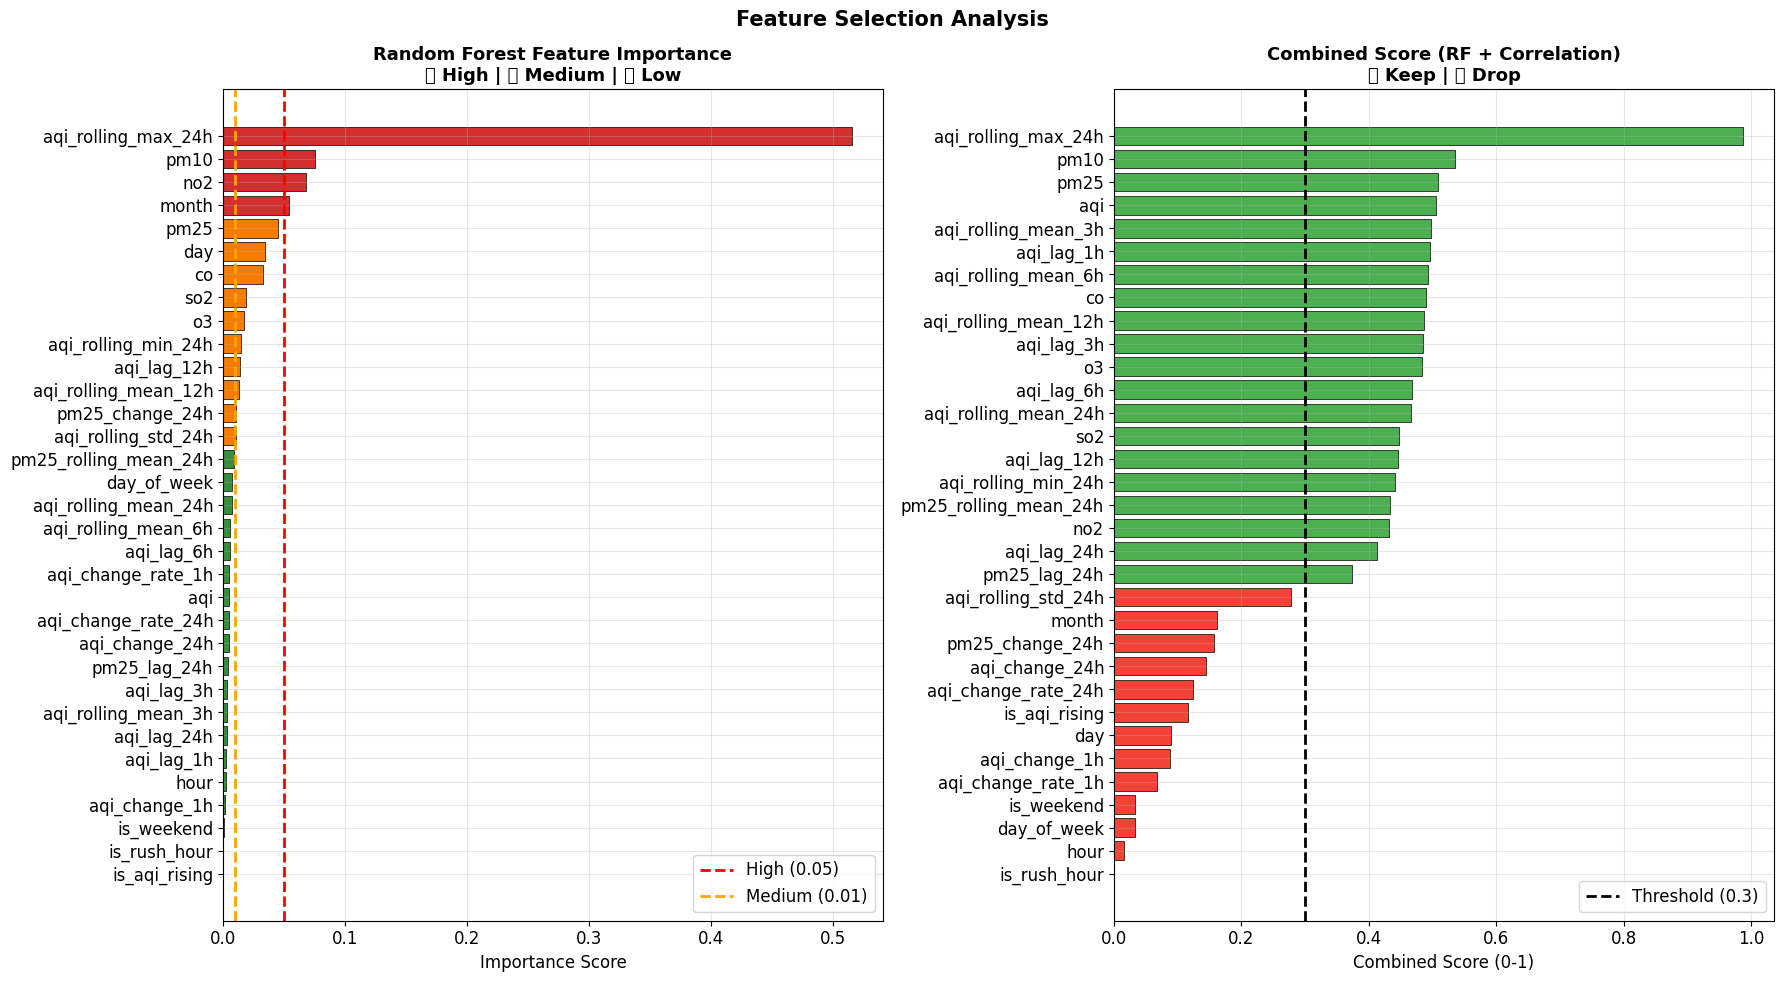

✅ Saved: eda_plots/feature_selection_combined.png


In [9]:
# ============================================================
# VISUALIZE - Feature Importance + Correlation Combined
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# --- Plot 1: RF Importance ---
imp_sorted = importance_df.sort_values('importance', ascending=True)
colors_imp = [
    '#d32f2f' if v >= 0.05 else
    '#f57c00' if v >= 0.01 else
    '#388e3c'
    for v in imp_sorted['importance']
]

axes[0].barh(imp_sorted['feature'], imp_sorted['importance'],
             color=colors_imp, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0.05, color='red', linestyle='--',
                linewidth=2, label='High (0.05)')
axes[0].axvline(x=0.01, color='orange', linestyle='--',
                linewidth=2, label='Medium (0.01)')
axes[0].set_title('Random Forest Feature Importance\n'
                  '🔴 High | 🟡 Medium | 🟢 Low',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Importance Score')
axes[0].legend()

# --- Plot 2: Combined Score ---
comb_sorted = combined.sort_values('combined_score', ascending=True)
colors_comb = [
    '#4CAF50' if v >= KEEP_THRESHOLD else '#f44336'
    for v in comb_sorted['combined_score']
]

axes[1].barh(comb_sorted.index, comb_sorted['combined_score'],
             color=colors_comb, edgecolor='black', linewidth=0.5)
axes[1].axvline(x=KEEP_THRESHOLD, color='black', linestyle='--',
                linewidth=2, label=f'Threshold ({KEEP_THRESHOLD})')
axes[1].set_title('Combined Score (RF + Correlation)\n'
                  '🟢 Keep | 🔴 Drop',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Combined Score (0-1)')
axes[1].legend()

plt.suptitle('Feature Selection Analysis',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_plots/feature_selection_combined.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: eda_plots/feature_selection_combined.png")

In [10]:
# ============================================================
# FINAL RECOMMENDATION SUMMARY
# ============================================================
print("\n" + "="*65)
print("📋 FINAL FEATURE SELECTION RECOMMENDATION")
print("="*65)

# Always keep these regardless
always_keep = [
    'aqi',        # Current AQI (most important!)
    'pm25',       # Main pollutant
    'pm10',       # Key pollutant
    'aqi_lag_24h' # Yesterday's AQI
]

# Final keep list
final_keep = list(set(keep_list + always_keep))
final_drop = [f for f in all_feature_cols
              if f not in final_keep]

print(f"\n✅ FEATURES TO KEEP ({len(final_keep)}):")
print("-"*40)
for i, feat in enumerate(
    sorted(final_keep,
           key=lambda x: combined.get('combined_score', {}).get(x, 0),
           reverse=True), 1
):
    score = combined.loc[feat, 'combined_score'] \
            if feat in combined.index else 1.0
    print(f"  {i:2d}. {feat:<35} score: {score:.3f}")

print(f"\n❌ FEATURES TO DROP ({len(final_drop)}):")
print("-"*40)
for i, feat in enumerate(final_drop, 1):
    score = combined.loc[feat, 'combined_score'] \
            if feat in combined.index else 0.0
    print(f"  {i:2d}. {feat:<35} score: {score:.3f}")

print(f"\n{'='*65}")
print(f"📊 SUMMARY:")
print(f"   Total features analyzed : {len(all_feature_cols)}")
print(f"   Recommended to KEEP     : {len(final_keep)}")
print(f"   Recommended to DROP     : {len(final_drop)}")
print(f"   Threshold used          : {KEEP_THRESHOLD}")
print(f"{'='*65}")
print(f"\n💡 NOTE: Features NOT dropped yet!")
print(f"   Review the list above carefully")
print(f"   Run next cell when ready to apply selection")


📋 FINAL FEATURE SELECTION RECOMMENDATION

✅ FEATURES TO KEEP (20):
----------------------------------------
   1. aqi_rolling_max_24h                 score: 0.986
   2. pm10                                score: 0.535
   3. pm25                                score: 0.509
   4. aqi                                 score: 0.505
   5. aqi_rolling_mean_3h                 score: 0.498
   6. aqi_lag_1h                          score: 0.496
   7. aqi_rolling_mean_6h                 score: 0.492
   8. co                                  score: 0.489
   9. aqi_rolling_mean_12h                score: 0.486
  10. aqi_lag_3h                          score: 0.484
  11. o3                                  score: 0.484
  12. aqi_lag_6h                          score: 0.467
  13. aqi_rolling_mean_24h                score: 0.465
  14. so2                                 score: 0.447
  15. aqi_lag_12h                         score: 0.445
  16. aqi_rolling_min_24h                 score: 0.441
  17. pm25_

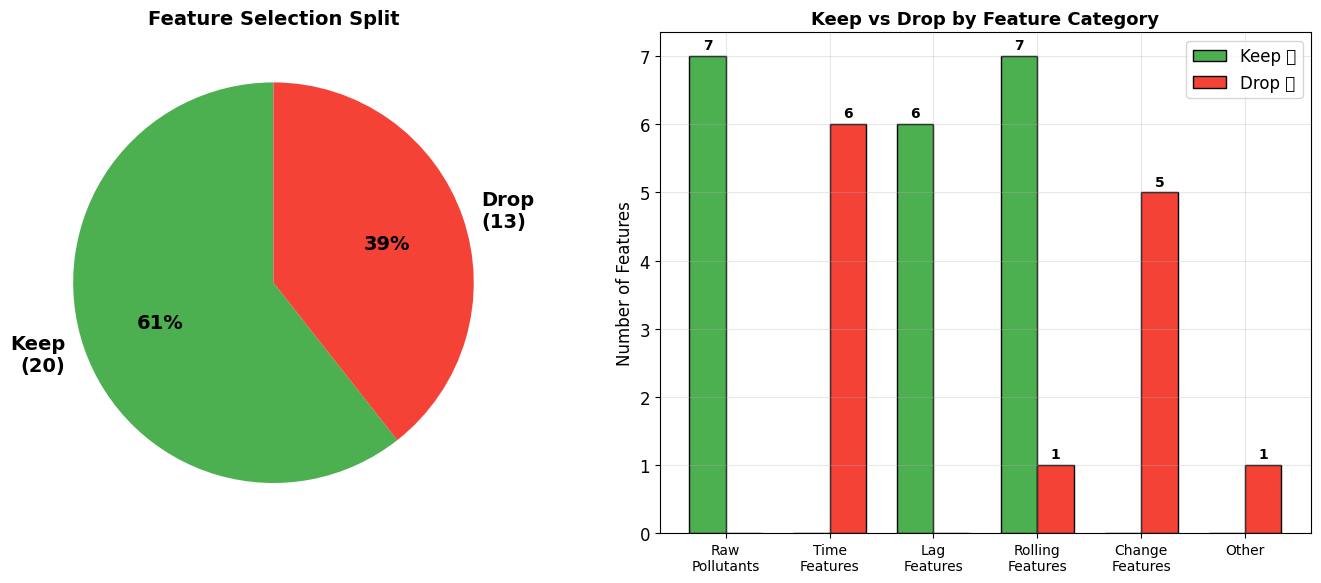


✅ All plots saved to eda_plots/
✅ Review the recommendations above
✅ Run the next cell ONLY when ready to apply!


In [12]:
# ============================================================
# VISUAL SUMMARY - Keep vs Drop
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
axes[0].pie(
    [len(final_keep), len(final_drop)],
    labels=[f'Keep\n({len(final_keep)})', f'Drop\n({len(final_drop)})'],
    colors=['#4CAF50', '#f44336'],
    autopct='%1.0f%%',
    startangle=90,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)
axes[0].set_title('Feature Selection Split',
                  fontsize=14, fontweight='bold')

# Bar showing keep vs drop per category
categories = {
    'Raw\nPollutants': (['aqi','pm25','pm10','o3','no2','so2','co'], '#2196F3'),
    'Time\nFeatures':  (['hour','day_of_week','month','day',
                          'is_weekend','season_encoded',
                          'is_rush_hour'], '#FF9800'),
    'Lag\nFeatures':   ([c for c in all_feature_cols if 'lag' in c], '#9C27B0'),
    'Rolling\nFeatures':([c for c in all_feature_cols if 'rolling' in c
                           or 'ema' in c], '#00BCD4'),
    'Change\nFeatures': ([c for c in all_feature_cols if 'change' in c
                           or 'rate' in c], '#F44336'),
    'Other':            ([c for c in all_feature_cols
                           if c not in ['aqi','pm25','pm10','o3',
                                        'no2','so2','co','hour',
                                        'day_of_week','month','day',
                                        'is_weekend','season_encoded',
                                        'is_rush_hour']
                           and 'lag' not in c
                           and 'rolling' not in c
                           and 'ema' not in c
                           and 'change' not in c
                           and 'rate' not in c], '#607D8B'),
}

cat_names, keep_counts, drop_counts = [], [], []

for cat, (feats, color) in categories.items():
    k = len([f for f in feats if f in final_keep])
    d = len([f for f in feats if f in final_drop])
    if k + d > 0:
        cat_names.append(cat)
        keep_counts.append(k)
        drop_counts.append(d)

x = range(len(cat_names))
width = 0.35

bars1 = axes[1].bar([i - width/2 for i in x], keep_counts,
                     width, label='Keep ✅', color='#4CAF50',
                     edgecolor='black')
bars2 = axes[1].bar([i + width/2 for i in x], drop_counts,
                     width, label='Drop ❌', color='#f44336',
                     edgecolor='black')

axes[1].set_title('Keep vs Drop by Feature Category',
                  fontsize=13, fontweight='bold')
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(cat_names, fontsize=10)
axes[1].set_ylabel('Number of Features')
axes[1].legend()

for bar in bars1:
    if bar.get_height() > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2.,
                     bar.get_height() + 0.1,
                     str(int(bar.get_height())),
                     ha='center', fontsize=10, fontweight='bold')

for bar in bars2:
    if bar.get_height() > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2.,
                     bar.get_height() + 0.1,
                     str(int(bar.get_height())),
                     ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_plots/keep_vs_drop_summary.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ All plots saved to eda_plots/")
print("✅ Review the recommendations above")
print("✅ Run the next cell ONLY when ready to apply!")

# ## 📊 **What This Does:**

# | Method | What It Checks |
# |--------|---------------|
# | **Correlation** | Linear relationship with each target |
# | **RF Importance** | Non-linear contribution to predictions |
# | **Combined Score** | Both methods averaged together |

# ---

# ## 🎯 **Output You'll See:**
# ```
# ✅ FEATURES TO KEEP (20):
#    1. aqi_lag_24h          score: 0.95
#    2. aqi_rolling_mean_24h score: 0.92
#    3. pm25                 score: 0.88
#    ...

# ❌ FEATURES TO DROP (15):
#    1. day                  score: 0.12
#    2. is_weekend           score: 0.18
#    ...

# 📊 SUMMARY:
#    Total analyzed : 35
#    Keep           : 20
#    Drop           : 15